![](https://d335luupugsy2.cloudfront.net/cms/files/198055/1601221653/$1arydmjjwl2)

- **Palestrante:** Milton Ossamu
- **Contatos:** https://www.linkedin.com/in/ossamum/

# Utilizando NLP para prever detratores de pesquisas de NPS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DATASET_NLP.csv')

In [3]:
df.head()

,DESCRICAO,MOTIVO
0,a internet funciona direito,FUNCIONAMENTO
1,a agilidade do serviço e a velocidade da inter...,FUNCIONAMENTO
2,"é muitas ligações de outras pessoas, que liga ...",OUTROS MOTIVOS
3,estão poupando de mandar visita técnica. o pro...,FUNCIONAMENTO
4,apesar de a internet ficar sempre fora o app e...,FUNCIONAMENTO


In [6]:
df.iloc[3, 0]

'estão poupando de mandar visita técnica. o problema ficou parcialmente resolvido.'

In [7]:
df.shape

(401, 2)

# EDA - Exploratory Data Analysis

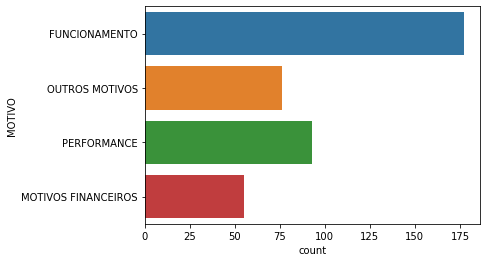

In [9]:
sns.countplot(data=df, y='MOTIVO');

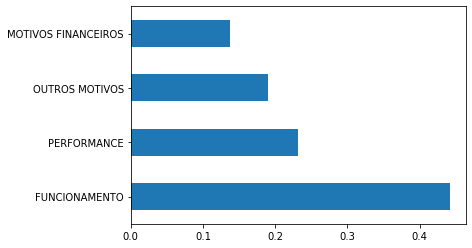

In [16]:
df['MOTIVO'].value_counts(normalize=True).plot(kind='barh');

# Wordcloud

In [18]:
from wordcloud import WordCloud

In [ ]:
# instalar pacote
!pip install wordcloud

In [19]:
df.head()

,DESCRICAO,MOTIVO
0,a internet funciona direito,FUNCIONAMENTO
1,a agilidade do serviço e a velocidade da inter...,FUNCIONAMENTO
2,"é muitas ligações de outras pessoas, que liga ...",OUTROS MOTIVOS
3,estão poupando de mandar visita técnica. o pro...,FUNCIONAMENTO
4,apesar de a internet ficar sempre fora o app e...,FUNCIONAMENTO


In [20]:
list_txt = []
class_names = df['MOTIVO'].unique()

In [21]:
class_names

array(['FUNCIONAMENTO', 'OUTROS MOTIVOS', 'PERFORMANCE',
       'MOTIVOS FINANCEIROS'], dtype=object)

In [22]:
for motivo in class_names:
    list_txt.append(' '.join(txt for txt in df[df['MOTIVO']==motivo]['DESCRICAO']))

In [27]:
class_names[0]

'FUNCIONAMENTO'

In [28]:
def plot_wordcloud(i, class_names=class_names, list_txt=list_txt, stopwords=None, figsize=(10, 6)):
    wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate_from_text(list_txt[i])
    
    print('===> MOTIVO:', class_names[i])
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

===> MOTIVO: FUNCIONAMENTO


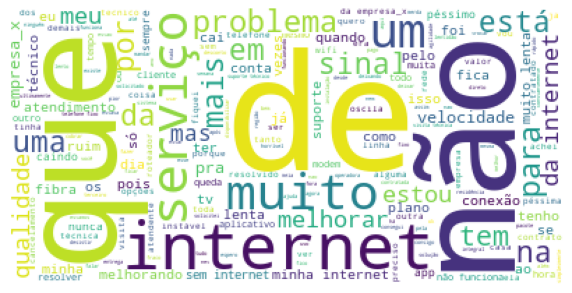

In [29]:
plot_wordcloud(0)

In [30]:
import nltk

In [31]:
stopwords = nltk.corpus.stopwords.words('portuguese')

In [33]:
stopwords.pop(12)

'não'

===> MOTIVO: FUNCIONAMENTO


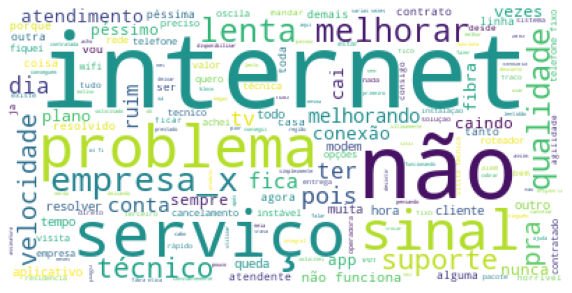

In [35]:
plot_wordcloud(0, stopwords=stopwords)

# Modeling

In [42]:
from sklearn.model_selection import train_test_split

In [36]:
df.head()

,DESCRICAO,MOTIVO
0,a internet funciona direito,FUNCIONAMENTO
1,a agilidade do serviço e a velocidade da inter...,FUNCIONAMENTO
2,"é muitas ligações de outras pessoas, que liga ...",OUTROS MOTIVOS
3,estão poupando de mandar visita técnica. o pro...,FUNCIONAMENTO
4,apesar de a internet ficar sempre fora o app e...,FUNCIONAMENTO


In [43]:
df['MOTIVO'].value_counts(True)

FUNCIONAMENTO          0.441397
PERFORMANCE            0.231920
OUTROS MOTIVOS         0.189526
MOTIVOS FINANCEIROS    0.137157
Name: MOTIVO, dtype: float64

In [44]:
def train_test(df, feat='DESCRICAO', target='MOTIVO'):
    df[target] = pd.Categorical(df[target])
    
    x, y = df[feat].values, df[target]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)
    return x_train, x_test, y_train, y_test

In [61]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import timeit
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, plot_confusion_matrix

In [62]:
from sklearn import __version__

In [63]:
__version__

'0.23.1'

In [64]:
def train_clf(df, param_grid, clf, stopwords=None, skf=StratifiedKFold(10), cmap='Blues'):
    df_pred = pd.DataFrame()
    
    x_train, x_test, y_train, y_test = train_test(df)
    
    print(f'Model: {clf.__class__.__name__}')
    start = timeit.default_timer()
        
    pipe = Pipeline([('vect', CountVectorizer(stop_words=stopwords)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', clf)])
    
    grid = GridSearchCV(pipe, param_grid, scoring='f1_weighted', cv=skf, n_jobs=-1)
    
    grid.fit(x_train, y_train)
    
    print(f'Executed in {round(timeit.default_timer() - start, 0)} secs')
    print(f'Best params: {grid.best_params_}')
    
    y_pred = grid.predict(x_test)
    print(classification_report(y_test, y_pred))
    
    df_pred['y_pred'] = y_pred.tolist()
    df_pred['y_test'] = y_test.tolist()
    
    plot_confusion_matrix(grid.best_estimator_, x_test, y_test,
                          cmap=cmap, xticks_rotation=45)
    plt.show()
    
    return df_pred, grid.best_estimator_

Model: MultinomialNB
Executed in 15.0 secs
Best params: {'clf__alpha': 0.034483724137931035, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
                     precision    recall  f1-score   support

      FUNCIONAMENTO       0.64      0.87      0.74        45
MOTIVOS FINANCEIROS       0.82      0.64      0.72        14
     OUTROS MOTIVOS       0.50      0.26      0.34        19
        PERFORMANCE       0.68      0.57      0.62        23

           accuracy                           0.65       101
          macro avg       0.66      0.58      0.60       101
       weighted avg       0.65      0.65      0.63       101



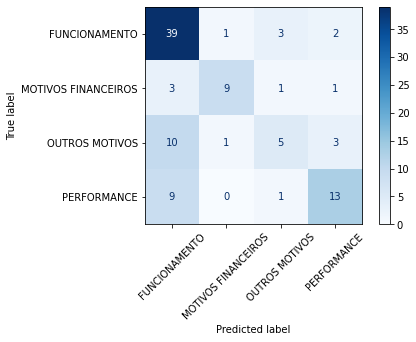

In [68]:
# NAIVE BAYES
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': np.linspace(1e-6, 1, 30)}

df_pred_nb, pipe_nb = train_clf(df, param_grid, MultinomialNB())

In [71]:
x_train, x_test, y_train, y_test = train_test(df)

In [72]:
y_test.value_counts()

FUNCIONAMENTO          45
PERFORMANCE            23
OUTROS MOTIVOS         19
MOTIVOS FINANCEIROS    14
Name: MOTIVO, dtype: int64

In [69]:
from sklearn.svm import SVC

Model: SVC
Executed in 1.0 secs
Best params: {'clf__kernel': 'linear', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
                     precision    recall  f1-score   support

      FUNCIONAMENTO       0.71      0.87      0.78        45
MOTIVOS FINANCEIROS       0.88      0.50      0.64        14
     OUTROS MOTIVOS       0.40      0.32      0.35        19
        PERFORMANCE       0.78      0.78      0.78        23

           accuracy                           0.69       101
          macro avg       0.69      0.62      0.64       101
       weighted avg       0.69      0.69      0.68       101



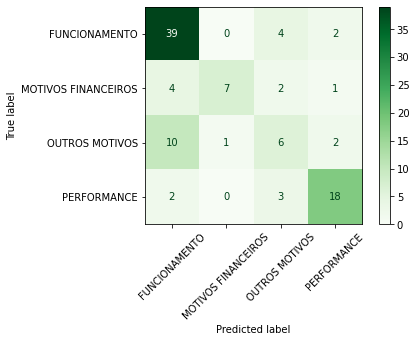

In [70]:
# SVM
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__kernel': ['rbf', 'linear']}

df_pred_svm, pipe_svm = train_clf(df, param_grid, SVC(), cmap='Greens')